### In this notebook:
XGBoost take as input:
- ERA5 values on the last 30 days
- Output of the encoder for MJO-ENSO variables
- Output of the encoder for the 10 days timeseries of ERA5 variables

In [3]:
ls

 Volume in drive C is OS
 Volume Serial Number is F2A2-B6C5

 Directory of c:\Users\marce\OneDrive\Desktop\POLIMI\tropical-cyclones-xai\notebooks\04_white_box_models

01/06/2024  17:01    <DIR>          .
01/06/2024  17:11    <DIR>          ..
01/06/2024  17:28           402,351 01_Decision_Trees_6zones.ipynb
01/06/2024  16:55         2,228,454 02_Decision_Trees_Z11.ipynb
01/06/2024  16:55           287,424 03_BRL_Z11.ipynb
01/06/2024  16:55           233,205 04_Rule_Fit_Z11.ipynb
01/06/2024  16:55           159,108 05_FromBRLtoDT.ipynb
               5 File(s)      3,310,542 bytes
               2 Dir(s)   2,613,100,544 bytes free


In [19]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from keras.models import load_model


import pickle
import metrics
import datashift

ModuleNotFoundError: No module named 'tabulate'

In [4]:
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.15.0


 # Loading Datasets

In [5]:
df_era5 = pd.read_csv('./DATASET_COMPLETED/ERA5_16zones_avg_std_10D_NoWindDirection.csv')
df_era5 = df_era5.set_index('DATE')
df_era5 = df_era5.drop(columns=['S.IndAll', 'S.IndGen'])
df_era5 = df_era5[df_era5.index > '1980-02']
df_era5 = df_era5[df_era5.index < '2022']

# Create MinMaxScaler instance
scaler = MinMaxScaler()
# Fit the scaler on the reshaped dataset and transform it
data_scaled = scaler.fit_transform(df_era5)
df_era5_scaled = pd.DataFrame(data_scaled, columns=df_era5.columns)
df_era5_scaled.index = df_era5.index
df_era5_scaled

,P_Mean_Z1-0,P_Mean_Z1-1,P_Mean_Z1-2,P_Mean_Z1-3,P_Mean_Z1-4,P_Mean_Z1-5,P_Mean_Z1-6,P_Mean_Z1-7,P_Mean_Z1-8,P_Mean_Z1-9,...,Air_Density_Std_Z16-1,Air_Density_Std_Z16-2,Air_Density_Std_Z16-3,Air_Density_Std_Z16-4,Air_Density_Std_Z16-5,Air_Density_Std_Z16-6,Air_Density_Std_Z16-7,Air_Density_Std_Z16-8,Air_Density_Std_Z16-9,Air_Density_Std_Z16-10
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,0.489865,...,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480,0.392453
1980-02-02,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,0.449898,...,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273,0.409480
1980-02-03,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,0.434279,...,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584,0.422273
1980-02-04,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,0.361763,...,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396,0.425584
1980-02-05,0.286090,0.348375,0.376618,0.412313,0.400255,0.364918,0.382609,0.416793,0.386992,0.370588,...,0.286136,0.363910,0.404121,0.376670,0.318328,0.273482,0.336515,0.403900,0.353448,0.402396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,0.509506,...,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458,0.382929
2021-12-28,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,0.513174,...,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145,0.261458
2021-12-29,0.429117,0.489694,0.459871,0.451993,0.383920,0.367969,0.454867,0.508562,0.545995,0.502857,...,0.255346,0.293302,0.425590,0.517221,0.435563,0.443043,0.280731,0.299484,0.300563,0.262145


In [6]:
df_mjo = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/MJO_30D_scaled.csv')
df_enso = pd.read_csv('./DATASET_COMPLETED/ensemble_dataset/ENSO_30D_scaled.csv')


In [7]:
def rewind_att(att_list, steps):
  new_list = []
  for elem in att_list:
    for i in range(steps):
      new_list.append('{}-{}'.format(elem,i+1))
  return new_list

attributes_list = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']
#attributes_selected = ['RMM1', 'RMM2', 'Phase', 'indocW', 'indocE']
attributes_selected = ['RMM1', 'RMM2', 'Phase', 'nino3', 'nino4', 'nino12', 'nino34', 'indocW','indocE']

df_mjo_enso = pd.merge(df_mjo, df_enso, on=["DATE"])
df_mjo_enso = df_mjo_enso.set_index('DATE')
df_mjo_enso = df_mjo_enso[df_mjo_enso.index < '2022']
df_mjo_enso = df_mjo_enso[rewind_att(attributes_selected, 30)]

#print(len(df_mjo), len(df_enso), len(df_mjo_enso))
df_mjo_enso

,RMM1-1,RMM1-2,RMM1-3,RMM1-4,RMM1-5,RMM1-6,RMM1-7,RMM1-8,RMM1-9,RMM1-10,...,indocE-21,indocE-22,indocE-23,indocE-24,indocE-25,indocE-26,indocE-27,indocE-28,indocE-29,indocE-30
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,0.492725,...,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084,0.540251
1980-02-02,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,0.484783,...,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535,0.536084
1980-02-03,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,0.479205,...,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311,0.527535
1980-02-04,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,0.477807,...,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140,0.518311
1980-02-05,0.482835,0.477843,0.446730,0.426263,0.443395,0.497201,0.543049,0.533406,0.520222,0.496491,...,0.557513,0.562821,0.564371,0.559889,0.550539,0.539860,0.529143,0.519671,0.512739,0.512140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,0.597357,...,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712,0.605784
2021-12-28,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,0.574846,...,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231,0.609712
2021-12-29,0.412768,0.430960,0.456721,0.459083,0.487810,0.506327,0.522359,0.524730,0.508447,0.536899,...,0.606413,0.613950,0.585440,0.580454,0.595150,0.576959,0.601620,0.613510,0.615770,0.612231


In [8]:
df_target = pd.read_csv('./DATASET_COMPLETED/old_dataset/ibtracs_hotzone.csv')
df_target = df_target.drop(columns=['Unnamed: 0'])
df_target = df_target.set_index('DATE')
# df_target['Label'] = df_target['S.IndAll'].apply(lambda x: 1 if x > 0 else 0)
df_target = df_target[df_target.index > '1980-02']
df_target = df_target[df_target.index < '2022']
df_target = df_target['TC_PRESENCE']

df_target

DATE
1980-02-01    1
1980-02-02    1
1980-02-03    1
1980-02-04    1
1980-02-05    0
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: TC_PRESENCE, Length: 15310, dtype: int64

# Manually feature selection


In [9]:
def is_exact_substring(main_string, substring):
    # Check if substring is in the main_string
    if substring in main_string:
        # Check if the substring is not followed by a digit
        index = main_string.find(substring)
        if index + len(substring) == len(main_string) or not main_string[index + len(substring)].isdigit():
            return True
    return False

def filter_features(df, feats):
  columns = df.columns
  selected_columns = []
  for col in columns:
    for feat in feats:
      if is_exact_substring(col, feat):
        selected_columns.append(col)
  return df[selected_columns]

#selected_meteo_feat = ['P_', 'Vor_850hPa_', 'Wind_Gust_', 'Wind_1000hPa', 'Wind_850hPa', 'Wind_300hPa', 'T_1000hPa', 'Air_Density']
selected_meteo_feat = ['P_', 'Vor_850hPa_', 'Wind_Gust_', 'Wind_850hPa', 'T_1000hPa', 'Air_Density']

selected_steps = ['-0']#, '-1', '-2', '-3']
selected_zones = ['_Z6', '_Z7', '_Z8', '_Z10', '_Z11', '_Z12']

print(8*4*6*2)

df_filtered = filter_features(df_era5, selected_meteo_feat)
df_filtered = filter_features(df_filtered, selected_steps)
df_filtered = filter_features(df_filtered, selected_zones)

cols = []
for elem in df_filtered.columns:
  cols.append(elem.replace('-0',''))
df_filtered.columns = cols

df_filtered

384


,P_Mean_Z6,P_Std_Z6,P_Mean_Z7,P_Std_Z7,P_Mean_Z8,P_Std_Z8,P_Mean_Z10,P_Std_Z10,P_Mean_Z11,P_Std_Z11,...,Air_Density_Mean_Z7,Air_Density_Std_Z7,Air_Density_Mean_Z8,Air_Density_Std_Z8,Air_Density_Mean_Z10,Air_Density_Std_Z10,Air_Density_Mean_Z11,Air_Density_Std_Z11,Air_Density_Mean_Z12,Air_Density_Std_Z12
DATE,,,,,,,,,,,,,,,,,,,,,
1980-02-01,100957.221037,98.226981,100716.899362,110.954003,100898.537857,42.079847,101160.381154,162.608610,100839.731017,181.191942,...,1.158570,0.002729,1.160804,0.001860,1.165962,0.004366,1.160672,0.002807,1.166578,0.003816
1980-02-02,101004.407341,138.445884,100629.340394,172.189124,100952.580738,30.567217,101175.070813,210.697971,100819.805114,275.843829,...,1.157692,0.003516,1.162563,0.002294,1.164303,0.004525,1.159397,0.003655,1.168184,0.005195
1980-02-03,100821.384484,158.350857,100747.493714,259.977220,101029.333065,44.676856,101009.562402,268.754270,100624.544895,484.595148,...,1.158588,0.004646,1.163153,0.002767,1.161825,0.004721,1.158297,0.006810,1.170660,0.005215
1980-02-04,100863.122198,110.958504,100997.447967,105.416374,100982.122188,62.055606,100649.448837,500.734373,100803.244697,515.555038,...,1.161303,0.003105,1.161169,0.002201,1.155346,0.007415,1.158986,0.008253,1.170316,0.004834
1980-02-05,100867.324384,63.357490,101062.650471,85.743984,100967.694804,46.121591,100700.955149,277.950996,100982.396277,245.186655,...,1.163095,0.004498,1.162400,0.002345,1.155461,0.004433,1.162109,0.005853,1.170961,0.004377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,101225.780524,76.108702,101209.769371,53.090754,101284.795735,64.435096,101370.495457,105.332435,101312.753918,37.618223,...,1.160783,0.001449,1.162443,0.002360,1.164344,0.004088,1.164909,0.001809,1.170542,0.003007
2021-12-28,101139.912903,69.396046,101140.970675,30.448369,101136.176497,60.054815,101317.765632,112.892557,101220.225639,49.067544,...,1.160024,0.001995,1.161684,0.002822,1.164901,0.004380,1.165014,0.003450,1.169654,0.003509
2021-12-29,101019.842059,64.047448,100973.454251,41.803667,101001.175509,60.403010,101193.367451,144.589589,101050.137778,77.453997,...,1.159012,0.001585,1.161012,0.002350,1.164047,0.005043,1.165850,0.005070,1.168802,0.003670


# Tree-Based models for classification

In [10]:
X_train = df_filtered[df_filtered.index < '2012'].values
X_test = df_filtered[df_filtered.index > '2012'].values

y_train = df_target[df_target.index < '2012'].values
y_test = df_target[df_target.index > '2012'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(11657, 72) (11657,)
(3653, 72) (3653,)


In [11]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
# Evaluate the model
y_pred   = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred, average='binary')  # Specify 'micro', 'macro', 'weighted', or 'binary'
recall   = recall_score(y_test, y_pred, average='binary')  # Specify 'micro', 'macro', 'weighted', or 'binary'

N_test = len(y_test)
fp = 0
n_cyclones_predicted = np.count_nonzero(y_pred)
n_cyclones = np.count_nonzero(y_test)

for i in range(N_test):
  if y_test[i] == 0 and y_pred[i] == 1:
    fp += 1

far = fp/n_cyclones_predicted
# Print the evaluation metrics
print(f"Accuracy    : {accuracy:.2f}")
print(f"F1 Score    : {f1:.2f}")
print(f"Recall      : {recall:.2f}")

print(f"N TC        : {n_cyclones}")
print(f"TC predicted: {n_cyclones_predicted}")
print(f"FAR         : {far:.2f}")

Accuracy    : 0.85
F1 Score    : 0.61
Recall      : 0.72
N TC        : 607
TC predicted: 832
FAR         : 0.47


In [ ]:
# from sklearn.tree import plot_tree

# plt.figure(figsize=(20, 10))
# plot_tree(clf, filled=True)
# plt.title("Decision tree trained on a subset of features")
# plt.show()

In [ ]:
idx = random.randint(0, X_test.shape[0]-1)
samples = X_test[idx]
target = y_test[idx]
pred = clf.predict(samples.reshape(1,-1))[0]
decision_paths = clf.decision_path(samples.reshape(1,-1))


print('SAMPLE IDX: ', idx)
print('TARGET:     ', target)
print('PREDICTED:  ', pred)

if target == pred == 1:
  print('TRUE POSITIVE')
elif target == pred == 0:
  print('TRUE NEGATIVE')

SAMPLE IDX:  1565
TARGET:      1
PREDICTED:   1
TRUE POSITIVE


In [ ]:
import pydotplus
import random
from sklearn import tree
from IPython.display import Image, display

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df_filtered.columns,
                                class_names=['Negative', 'Positive'],
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)

# empty all nodes, i.e.set color to white and number of samples to zero
for node in graph.get_node_list():
    if node.get_attributes().get('label') is None:
        continue
    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')

for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue
        green_light = True
        node = graph.get_node(str(n))[0]
        node.set_fillcolor('green')
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
        node.set('label', '<br/>'.join(labels))


filename = 'tree.png'
graph.write_png(filename)
# Display the graph in the notebook
display(Image(filename=filename))

Output hidden; open in https://colab.research.google.com to view.

SAMPLE IDX:  1565
TARGET:      1
PREDICTED:   [1]
[(<pydotplus.graphviz.Node object at 0x786710d306d0>, <pydotplus.graphviz.Node object at 0x786709591c00>), (<pydotplus.graphviz.Node object at 0x786709591c00>, <pydotplus.graphviz.Node object at 0x7867095938e0>), (<pydotplus.graphviz.Node object at 0x7867095938e0>, <pydotplus.graphviz.Node object at 0x7866e28ad9c0>), (<pydotplus.graphviz.Node object at 0x7866e28ad9c0>, <pydotplus.graphviz.Node object at 0x7866e28afa60>), (<pydotplus.graphviz.Node object at 0x7866e28afa60>, <pydotplus.graphviz.Node object at 0x7866e2561b40>), (<pydotplus.graphviz.Node object at 0x7866e2561b40>, <pydotplus.graphviz.Node object at 0x7866e2563be0>), (<pydotplus.graphviz.Node object at 0x7866e2563be0>, <pydotplus.graphviz.Node object at 0x78670f2d9cc0>), (<pydotplus.graphviz.Node object at 0x78670f2d9cc0>, <pydotplus.graphviz.Node object at 0x78670f2dbd60>), (<pydotplus.graphviz.Node object at 0x78670f2dbd60>, <pydotplus.graphviz.Node object at 0x78670c3cde4

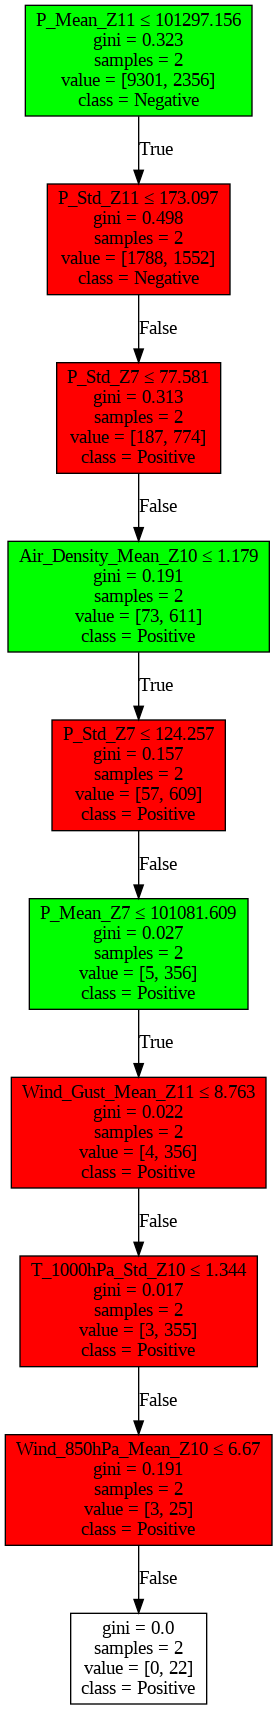

In [ ]:
# idx = random.randint(0, X_test.shape[0]-1)
samples = X_test[idx]
target = y_test[idx]
decision_paths = clf.decision_path(samples.reshape(1,-1))

print('SAMPLE IDX: ', idx)
print('TARGET:     ', target)
print('PREDICTED:  ', clf.predict(samples.reshape(1,-1)))

prediction_nodes = []
decisions = []
prev_node_idx = 0
for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
        if node_value == 0:
            continue

        if n == prev_node_idx + 1:
          decisions.append(True)
        else:
          decisions.append(False)
        prev_node_idx = n

        node = graph.get_node(str(n))[0]
        prediction_nodes.append(node)
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
        node.set('label', '<br/>'.join(labels))

# Create a Dot object representing the graph
graph_path = pydotplus.Dot(graph_type='digraph')

# Add nodes to the graph
for node in prediction_nodes:
    node.set_shape('box')
    node.set_style('filled')
    node.set_color('black')
    node.set_fillcolor('white')
    graph_path.add_node(node)

# # Example edges (you may need to specify edges based on your use case)
edges = []
for i in range(len(prediction_nodes)-1):
  edges.append((prediction_nodes[i], prediction_nodes[i+1]))
print(edges)
# # Add edges to the graph
j = 1
for edge in edges:
    if decisions[j]:
      edge[0].set_fillcolor('green')
      graph_path.add_edge(pydotplus.Edge(edge[0], edge[1], label='True'))
    else:
      edge[0].set_fillcolor('red')
      graph_path.add_edge(pydotplus.Edge(edge[0], edge[1], label='False'))
    j +=1

# Save the graph as a PNG file
graph_file = 'example_graph.png'
graph_path.write_png(graph_file)

# Display the graph in the notebook
display(Image(filename=graph_file))

# Analyze all the rules to classify a tropical cyclone

Consider all the path to reach a tropical cyclone prediction


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import _tree

def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []

    def recurse(node, path, paths):

        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    rules = []
    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]

    return rules



rules = get_rules(clf, df_filtered.columns, ['Neg', 'Pos'])
positive_rules = []
for r in rules:
  if 'then class: Pos' in r:
    positive_rules.append(r)
    print(r)

if (P_Mean_Z11 <= 101297.156) and (P_Std_Z11 > 173.097) and (P_Std_Z7 > 77.581) and (Air_Density_Mean_Z10 <= 1.179) and (P_Std_Z7 > 124.257) and (P_Mean_Z7 <= 101081.609) and (Wind_Gust_Mean_Z11 > 8.763) and (T_1000hPa_Std_Z10 <= 1.344) then class: Pos (proba: 100.0%) | based on 330 samples
if (P_Mean_Z11 <= 101297.156) and (P_Std_Z11 > 173.097) and (P_Std_Z7 > 77.581) and (Air_Density_Mean_Z10 <= 1.179) and (P_Std_Z7 <= 124.257) and (Air_Density_Mean_Z11 <= 1.169) and (T_1000hPa_Std_Z12 > 0.53) and (T_1000hPa_Mean_Z12 > 296.923) and (Wind_Gust_Std_Z12 > 0.88) and (Wind_850hPa_Mean_Z6 > 2.65) and (T_1000hPa_Std_Z11 > 0.414) and (Air_Density_Std_Z6 > 0.002) and (T_1000hPa_Std_Z7 <= 0.833) and (T_1000hPa_Std_Z12 <= 1.402) and (P_Std_Z7 > 79.948) then class: Pos (proba: 100.0%) | based on 155 samples
if (P_Mean_Z11 <= 101297.156) and (P_Std_Z11 <= 173.097) and (P_Std_Z8 > 130.84) and (T_1000hPa_Std_Z8 > 0.472) and (Wind_850hPa_Std_Z8 > 2.142) and (Air_Density_Mean_Z12 <= 1.182) and (Wind_

In [ ]:
class Rule():
  def __init__(self, name, depth):
    self.name = name
    self.depth = depth
    self.occurences = 1

  def __str__(self):
    return('RULE: {}   Depth: {}   Occurences: {}'.format(self.name, self.depth, self.occurences) )

  def increase_occ(self):
    self.occurences += 1

r_test = Rule('ciao > 4', 4)
print(r_test)

RULE: ciao > 4   Depth: 4   Occurences: 1


In [ ]:
import re
rules_dict = {}

for path in positive_rules:
  # print(path)
  # Use regex to find all substrings inside round brackets
  rules = re.findall(r'\((.*?)\)', path)
  for i in range(len(rules)):
    if 'P_' in rules[i]:
      if rules[i] in rules_dict:
        rules_dict[rules[i]].increase_occ()
      else:
        rules_dict[rules[i]] = Rule(rules[i], i)


print('From this decision tree we can extract {} paths to classify a TC'.format(len(positive_rules)))
for elem in rules_dict.values():
  if 'P_Mean' in elem.name:
    print(elem)

From this decision tree we can extract 384 paths to classify a TC
RULE: P_Mean_Z11 <= 101297.156   Depth: 0   Occurences: 165
RULE: P_Mean_Z7 <= 101081.609   Depth: 5   Occurences: 4
RULE: P_Mean_Z11 > 101297.156   Depth: 0   Occurences: 219
RULE: P_Mean_Z6 <= 101001.57   Depth: 4   Occurences: 8
RULE: P_Mean_Z12 <= 101373.152   Depth: 5   Occurences: 6
RULE: P_Mean_Z7 <= 100874.414   Depth: 7   Occurences: 4
RULE: P_Mean_Z10 <= 101270.734   Depth: 11   Occurences: 2
RULE: P_Mean_Z12 <= 101130.961   Depth: 8   Occurences: 1
RULE: P_Mean_Z6 <= 101255.184   Depth: 2   Occurences: 132
RULE: P_Mean_Z8 > 100929.047   Depth: 9   Occurences: 1
RULE: P_Mean_Z6 <= 101138.75   Depth: 4   Occurences: 3
RULE: P_Mean_Z8 <= 100939.164   Depth: 6   Occurences: 1
RULE: P_Mean_Z6 > 101255.184   Depth: 2   Occurences: 63
RULE: P_Mean_Z12 <= 101649.41   Depth: 4   Occurences: 3
RULE: P_Mean_Z7 > 100874.414   Depth: 7   Occurences: 5
RULE: P_Mean_Z7 > 100980.629   Depth: 12   Occurences: 10
RULE: P_Mean_Z